## 範例重點
* 學習如何在 keras 中加入 EarlyStop
* 知道如何設定監控目標
* 比較有無 earlystopping 對 validation 的影響

In [1]:
import os
import keras
import tensorflow as tf
# 本範例不需使用 GPU, 將 GPU 設定為 "無"
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = tf.keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 9s 0us/step


In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = tf.keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
"""
# 載入 Callbacks, 並將 monitor 設定為監控 validation loss

參數說明：
patience: 經過多少epochs後仍然沒有改善模型效能時停止訓練。
verbose: 運作狀況

使用說明：先定義出 Early stopping 的規則，再放入模型訓練中。

"""

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

from keras.callbacks import EarlyStopping

earlystop = EarlyStopping(monitor="val_loss", 
                          patience=5, 
                          verbose=1
                          )

In [ ]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = tf.keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[earlystop]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

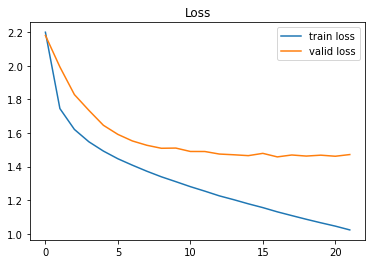

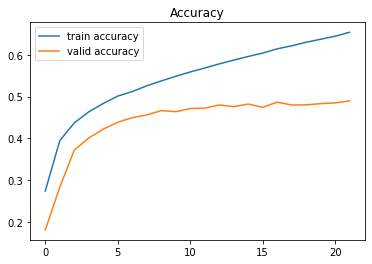

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [12]:
from keras.callbacks import EarlyStopping

earlystop = EarlyStopping(monitor="val_loss", 
                          patience=10, 
                          verbose=1
                          )

In [13]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = tf.keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[earlystop]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 batch_normalization_9 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 batch_normalization_10 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 hidden_layer3 (Dense)       (None, 128)               3289

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/50
49/49 [==============================] - 2s 19ms/step - loss: 2.1875 - accuracy: 0.2746 - val_loss: 2.1177 - val_accuracy: 0.2399
Epoch 2/50
49/49 [==============================] - 1s 14ms/step - loss: 1.7405 - accuracy: 0.3904 - val_loss: 1.9443 - val_accuracy: 0.3072
Epoch 3/50
49/49 [==============================] - 1s 13ms/step - loss: 1.6164 - accuracy: 0.4337 - val_loss: 1.8204 - val_accuracy: 0.3518
Epoch 4/50
49/49 [==============================] - 1s 20ms/step - loss: 1.5402 - accuracy: 0.4604 - val_loss: 1.7163 - val_accuracy: 0.3956
Epoch 5/50
49/49 [==============================] - 1s 17ms/step - loss: 1.4851 - accuracy: 0.4803 - val_loss: 1.6428 - val_accuracy: 0.4206
Epoch 6/50
49/49 [==============================] - 1s 24ms/step - loss: 1.4383 - accuracy: 0.4974 - val_loss: 1.5865 - val_accuracy: 0.4431
Epoch 7/50
49/49 [==============================] - 1s 22ms/step - loss: 1.3971 - accuracy: 0.5127 - val_loss: 1.5572 - val_accuracy: 0.4527
Epoch 8/50
49

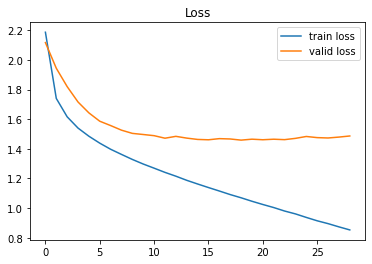

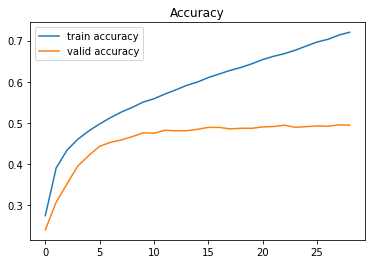

In [14]:
n

In [15]:
from keras.callbacks import EarlyStopping

earlystop = EarlyStopping(monitor="val_loss", 
                          patience=25, 
                          verbose=1
                          )

In [16]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = tf.keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[earlystop]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 batch_normalization_12 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 batch_normalization_13 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 hidden_layer3 (Dense)       (None, 128)               3289

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/50
49/49 [==============================] - 3s 19ms/step - loss: 2.2307 - accuracy: 0.2656 - val_loss: 2.1406 - val_accuracy: 0.1969
Epoch 2/50
49/49 [==============================] - 1s 14ms/step - loss: 1.7498 - accuracy: 0.3939 - val_loss: 1.9718 - val_accuracy: 0.2826
Epoch 3/50
49/49 [==============================] - 1s 14ms/step - loss: 1.6207 - accuracy: 0.4343 - val_loss: 1.8312 - val_accuracy: 0.3646
Epoch 4/50
49/49 [==============================] - 1s 15ms/step - loss: 1.5459 - accuracy: 0.4603 - val_loss: 1.7134 - val_accuracy: 0.4082
Epoch 5/50
49/49 [==============================] - 1s 14ms/step - loss: 1.4901 - accuracy: 0.4793 - val_loss: 1.6309 - val_accuracy: 0.4384
Epoch 6/50
49/49 [==============================] - 1s 14ms/step - loss: 1.4459 - accuracy: 0.4966 - val_loss: 1.5959 - val_accuracy: 0.4465
Epoch 7/50
49/49 [==============================] - 1s 13ms/step - loss: 1.4069 - accuracy: 0.5100 - val_loss: 1.5526 - val_accuracy: 0.4565
Epoch 8/50
49

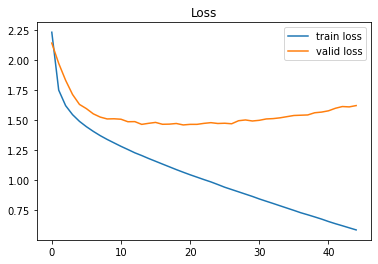

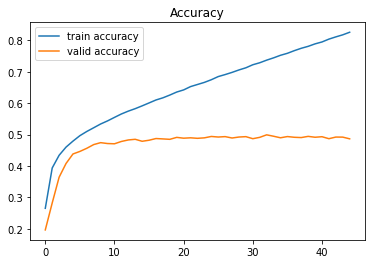

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()